In [1]:
# Import components
import datetime as dt
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
from matplotlib import pyplot as pltw
from pmdarima import arima, datasets, model_selection, utils
from scipy import spatial
from scipy.spatial import distance
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import STL

warnings.simplefilter("ignore")

plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro"
plt.style.use("ggplot")  # グラフのスタイル
plt.rcParams["figure.figsize"] = [12, 9]  # グラフサイズ設定

In [2]:
df = pd.read_csv("../datasets/fixed_battery_log_2_copy.csv")
df["date"] = pd.to_datetime(df["date"])
users = df["User"].unique()

In [4]:
def cos_sim(v1, v2):
    if np.isnan(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))):
        return 0
    else:
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [25]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
score_G_raw = []
score_I_raw = []

raw_i_Q_avg_q = []
raw_t_T_avg_q = []
raw_t_Q_avg_q = []

clf = LocalOutlierFactor(n_neighbors=2)
days = [30]
weekdays = df["weekday"].unique()

for a in range(len(days)):
    diff_day_1 = days[a]
    for b in range(len(days)):
        diff_day_2 = days[b]
        for h in range(len(users)):
            user = users[h]
            for i in range(0, 101):
                first_date = first_date_cand[
                    np.random.randint(0, len(first_date_cand), 1)
                ]
                last_date = first_date + dt.timedelta(days=diff_day_1)
                weekday = np.random.choice(weekdays)
                imposters = users.copy()
                imposters = imposters[~(imposters == user)]
                imposter = np.random.choice(imposters)
                t_Q_O = pd.DataFrame(
                    df.loc[
                        (df["User"] == user)
                        & (df["state"] == "ON")
                        & (df["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (df["date"] < last_date[0])
                        & (df["weekday"] == weekday)
                    ][["battery", "time_to_num"]].copy()
                )
                t_Q_O = t_Q_O.sort_values("time_to_num").reset_index(drop=True)

                t_T_O = pd.DataFrame(
                    df.loc[
                        (df["User"] == user)
                        & (df["state"] == "ON")
                        & (df["date"] > (first_date[0] - dt.timedelta(days=diff_day_2)))
                        & (df["date"] < (first_date[0]))
                        & (df["weekday"] == weekday)
                    ][["battery", "time_to_num"]].copy()
                )
                t_T_O = t_T_O.sort_values("time_to_num").reset_index(drop=True)

                i_Q_O = pd.DataFrame(
                    df.loc[
                        (df["User"] == imposter)
                        & (df["state"] == "ON")
                        & (df["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (df["date"] < last_date[0])
                        & (df["weekday"] == weekday)
                    ][["battery", "time_to_num"]].copy()
                )
                i_Q_O = i_Q_O.sort_values("time_to_num").reset_index(drop=True)

                raw_t_Q_q = []
                raw_t_T_q = []
                raw_i_Q_q = []
                for j in range(0, 24):
                    # print("{}:H".format(j))
                    raw_t_Q = t_Q_O.loc[
                        (t_Q_O["time_to_num"] > 3600 * j)
                        & (t_Q_O["time_to_num"] < 3600 * (j + 1))
                    ]["battery"]
                    if len(raw_t_Q) != 0:
                        raw_t_Q_q.append(raw_t_Q.values.mean())
                    else:
                        raw_t_Q_q.append(0)

                    raw_t_T = t_T_O.loc[
                        (t_T_O["time_to_num"] > 3600 * j)
                        & (t_T_O["time_to_num"] < 3600 * (j + 1))
                    ]["battery"]
                    if len(raw_t_T) != 0:
                        raw_t_T_q.append(raw_t_T.values.mean())
                    else:
                        raw_t_T_q.append(0)

                    raw_i_Q = i_Q_O.loc[
                        (i_Q_O["time_to_num"] > 3600 * j)
                        & (i_Q_O["time_to_num"] < 3600 * (j + 1))
                    ]["battery"]
                    if len(raw_i_Q) != 0:
                        raw_i_Q_q.append(raw_i_Q.values.mean())
                    else:
                        raw_i_Q_q.append(0)
                score_G_raw.append(cos_sim(raw_t_T_q, raw_t_Q_q))
                score_I_raw.append(cos_sim(raw_t_T_q, raw_i_Q_q))
        # print(score_G_raw)
        # print(score_I_raw)
        grand_truth_raw = np.concatenate(
            (np.ones(len(score_G_raw)), np.zeros(len(score_I_raw)))
        )
        score_raw = np.concatenate((score_G_raw, score_I_raw))
        far, tpr, threshold = metrics.roc_curve(grand_truth_raw, score_raw)
        auc = metrics.auc(far, tpr)
        frr = 1.0 - tpr
        eer_raw = far[np.where((far - frr) < 0)[0][-1]]
        # print("RAW")
        print(eer_raw)
print("FIN")

0.46163366336633666
FIN


In [26]:
len(i_Q_O)

10

In [27]:
len(t_T_O)

7

In [28]:
len(t_Q_O)

10

In [29]:
far_kai = pd.DataFrame(far[1:-1]).copy().set_index(threshold[1:-1])
frr_kai = pd.DataFrame(frr[1:-1]).copy().set_index(threshold[1:-1])

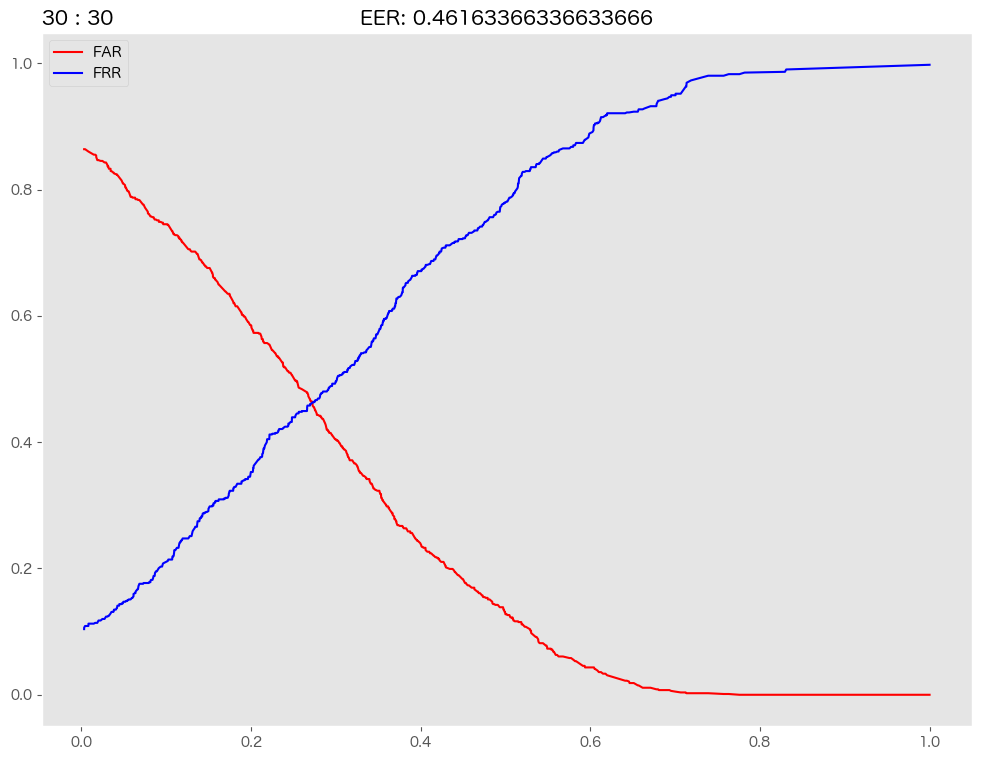

In [30]:
fig = plt.figure()
plt.title(f"{diff_day_1} : {diff_day_2}", loc="left")
plt.title(f"EER: {eer_raw}", loc="center")
# plt.title(f"length: {len(t_T)}:{len(t_Q)}:{len(i_Q)}", loc="right")

plt.plot(far_kai, color="r", label="FAR")
plt.plot(frr_kai, color="b", label="FRR")
plt.legend()
plt.grid()
plt.show()

In [37]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
score_G_raw = []
score_I_raw = []

raw_i_Q_avg_q = []
raw_t_T_avg_q = []
raw_t_Q_avg_q = []

test_t_Q = []
test_t_T = []
test_i_Q = []

clf = LocalOutlierFactor(n_neighbors=2)
days = [7]
weekdays = df["weekday"].unique()

for a in range(len(days)):
    diff_day_1 = days[a]
    for b in range(len(days)):
        diff_day_2 = days[b]
        for h in range(len(users)):
            user = users[h]
            for i in range(0, 101):
                first_date = first_date_cand[
                    np.random.randint(0, len(first_date_cand), 1)
                ]
                last_date = first_date + dt.timedelta(days=diff_day_1)
                weekday = np.random.choice(weekdays)
                imposters = users.copy()
                imposters = imposters[~(imposters == user)]
                imposter = np.random.choice(imposters)
                t_Q_O = pd.DataFrame(
                    df.loc[
                        (df["User"] == user)
                        & (df["state"] == "ON")
                        & (df["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (df["date"] < last_date[0])
                        & (df["weekday"] == weekday)
                    ][["battery", "time_to_num"]].copy()
                )
                t_Q_O = t_Q_O.sort_values("time_to_num").reset_index(drop=True)
                q1 = t_Q_O.battery.quantile(0.25)
                q3 = t_Q_O.battery.quantile(0.75)
                t_Q_O = t_Q_O.query("@q1 < battery < @q3")

                t_T_O = pd.DataFrame(
                    df.loc[
                        (df["User"] == user)
                        & (df["state"] == "ON")
                        & (df["date"] > (first_date[0] - dt.timedelta(days=diff_day_2)))
                        & (df["date"] < (first_date[0]))
                        & (df["weekday"] == weekday)
                    ][["battery", "time_to_num"]].copy()
                )
                t_T_O = t_T_O.sort_values("time_to_num").reset_index(drop=True)
                q1 = t_T_O.battery.quantile(0.25)
                q3 = t_T_O.battery.quantile(0.75)
                t_T_O = t_T_O.query("@q1 < battery < @q3")

                i_Q_O = pd.DataFrame(
                    df.loc[
                        (df["User"] == imposter)
                        & (df["state"] == "ON")
                        & (df["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (df["date"] < last_date[0])
                        & (df["weekday"] == weekday)
                    ][["battery", "time_to_num"]].copy()
                )
                i_Q_O = i_Q_O.sort_values("time_to_num").reset_index(drop=True)
                q1 = i_Q_O.battery.quantile(0.25)
                q3 = i_Q_O.battery.quantile(0.75)
                i_Q_O = i_Q_O.query("@q1 < battery < @q3")

                raw_t_Q_q = []
                raw_t_T_q = []
                raw_i_Q_q = []
                for j in range(0, 24):
                    # print("{}:H".format(j))
                    raw_t_Q = t_Q_O.loc[
                        (t_Q_O["time_to_num"] > 3600 * j)
                        & (t_Q_O["time_to_num"] < 3600 * (j + 1))
                    ]["battery"]
                    if len(raw_t_Q) != 0:
                        raw_t_Q_q.append(raw_t_Q.values.mean())
                    else:
                        raw_t_Q_q.append(0)

                    raw_t_T = t_T_O.loc[
                        (t_T_O["time_to_num"] > 3600 * j)
                        & (t_T_O["time_to_num"] < 3600 * (j + 1))
                    ]["battery"]
                    if len(raw_t_T) != 0:
                        raw_t_T_q.append(raw_t_T.values.mean())
                    else:
                        raw_t_T_q.append(0)

                    raw_i_Q = i_Q_O.loc[
                        (i_Q_O["time_to_num"] > 3600 * j)
                        & (i_Q_O["time_to_num"] < 3600 * (j + 1))
                    ]["battery"]
                    if len(raw_i_Q) != 0:
                        raw_i_Q_q.append(raw_i_Q.values.mean())
                    else:
                        raw_i_Q_q.append(0)

                test_t_Q.append(raw_t_Q_q)
                test_t_T.append(raw_t_T_q)
                test_i_Q.append(raw_i_Q_q)
                score_G_raw.append(cos_sim(raw_t_T_q, raw_t_Q_q))
                score_I_raw.append(cos_sim(raw_t_T_q, raw_i_Q_q))
        grand_truth_raw = np.concatenate(
            (np.ones(len(score_G_raw)), np.zeros(len(score_I_raw)))
        )
        score_raw = np.concatenate((score_G_raw, score_I_raw))
        far, tpr, threshold = metrics.roc_curve(grand_truth_raw, score_raw)
        auc = metrics.auc(far, tpr)
        frr = 1.0 - tpr
        eer_raw = far[np.where((far - frr) < 0)[0][-1]]
        # print("Q13")
        print(eer_raw)
print("FIN")

0.0037128712871287127
FIN


In [38]:
far_kai = pd.DataFrame(far[1:-1]).copy().set_index(threshold[1:-1])
frr_kai = pd.DataFrame(frr[1:-1]).copy().set_index(threshold[1:-1])
far_kai

,0
1.000000,0.001238
0.661201,0.002475
0.603628,0.002475
0.562617,0.002475
0.548086,0.002475
0.468914,0.003713


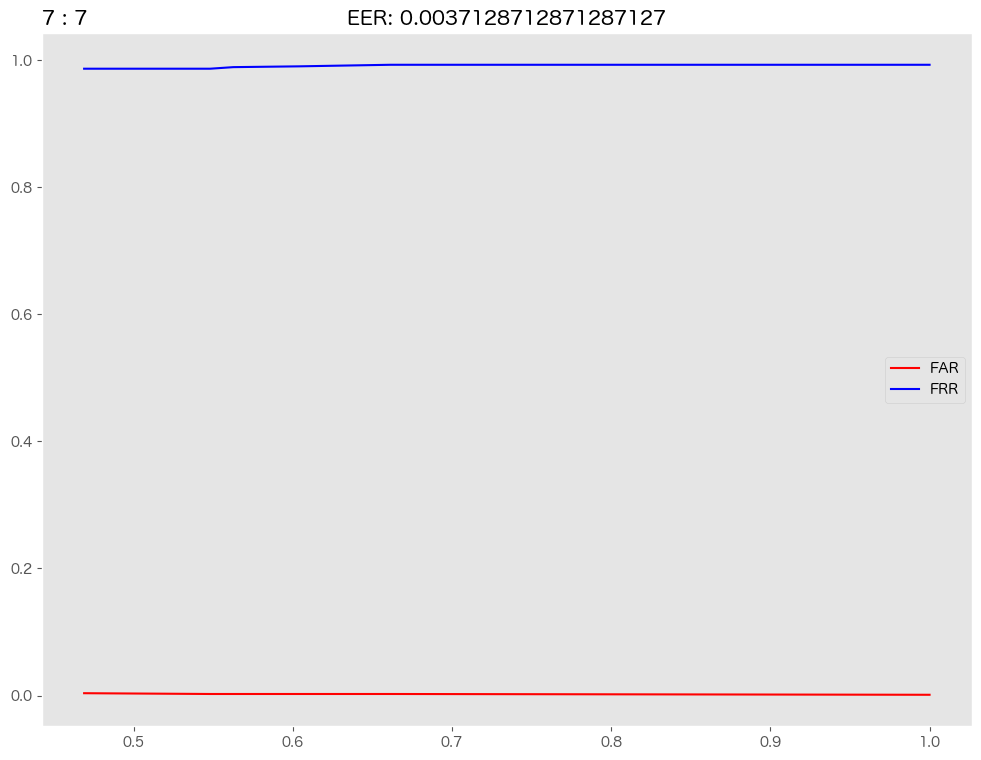

In [39]:
fig = plt.figure()
plt.title(f"{diff_day_1} : {diff_day_2}", loc="left")
plt.title(f"EER: {eer_raw}", loc="center")
# plt.title(f"length: {len(t_T)}:{len(t_Q)}:{len(i_Q)}", loc="right")

plt.plot(far_kai, color="r", label="FAR")
plt.plot(frr_kai, color="b", label="FRR")
plt.legend()
plt.grid()
plt.show()

In [33]:
far - frr

array([-1.        , -0.98143564, -0.98019802, -0.97524752, -0.9740099 ,
       -0.96410891, -0.95792079, -0.95544554, -0.94925743, -0.9480198 ,
       -0.94678218, -0.94183168, -0.94059406, -0.93935644, -0.93564356,
       -0.93316832, -0.92821782, -0.92574257, -0.9220297 , -0.91955446,
       -0.91707921, -0.91460396, -0.91212871, -0.90965347, -0.90841584,
       -0.90470297, -0.90346535, -0.9009901 , -0.89975248, -0.89727723,
       -0.89232673, -0.89108911, -0.88366337, -0.88118812, -0.8799505 ,
       -0.87871287, -0.86633663, -0.86509901, -0.86014851, -0.85519802,
       -0.8539604 , -0.8490099 , -0.84529703, -0.84158416, -0.83663366,
       -0.83044554, -0.82549505, -0.82054455, -0.81806931, -0.81435644,
       -0.81188119, -0.81064356, -0.80569307, -0.80445545, -0.80321782,
       -0.80074257, -0.79826733, -0.79207921, -0.78836634, -0.78712871,
        1.        ])

In [31]:
far[np.where((far - frr) < 0)[0][-1]]

0.1

In [51]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
score_G_raw = []
score_I_raw = []

raw_i_Q_avg_q = []
raw_t_T_avg_q = []
raw_t_Q_avg_q = []

clf = LocalOutlierFactor(n_neighbors=2)
days = [30]
weekdays = df["weekday"].unique()

for a in range(len(days)):
    diff_day_1 = days[a]
    for b in range(len(days)):
        diff_day_2 = days[b]
        for h in range(len(users)):
            user = users[h]
            for i in range(0, 101):
                first_date = first_date_cand[
                    np.random.randint(0, len(first_date_cand), 1)
                ]
                last_date = first_date + dt.timedelta(days=diff_day_1)
                weekday = np.random.choice(weekdays)
                imposters = users.copy()
                imposters = imposters[~(imposters == user)]
                imposter = np.random.choice(imposters)
                t_Q_O = pd.DataFrame(
                    df.loc[
                        (df["User"] == user)
                        & (df["state"] == "ON")
                        & (df["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (df["date"] < last_date[0])
                        & (df["weekday"] == weekday)
                    ][["battery", "time_to_num"]].copy()
                )
                t_Q_O = t_Q_O.sort_values("time_to_num").reset_index(drop=True)
                t_Q = np.array(t_Q_O)
                t_T_O = pd.DataFrame(
                    df.loc[
                        (df["User"] == user)
                        & (df["state"] == "ON")
                        & (df["date"] > (first_date[0] - dt.timedelta(days=diff_day_2)))
                        & (df["date"] < (first_date[0]))
                        & (df["weekday"] == weekday)
                    ][["battery", "time_to_num"]].copy()
                )
                t_T_O = t_T_O.sort_values("time_to_num").reset_index(drop=True)
                t_T = np.array(t_T_O)
                i_Q_O = pd.DataFrame(
                    df.loc[
                        (df["User"] == imposter)
                        & (df["state"] == "ON")
                        & (df["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (df["date"] < last_date[0])
                        & (df["weekday"] == weekday)
                    ][["battery", "time_to_num"]].copy()
                )
                i_Q_O = i_Q_O.sort_values("time_to_num").reset_index(drop=True)
                i_Q = np.array(i_Q_O)
                raw_t_Q_q = []
                raw_t_T_q = []
                raw_i_Q_q = []
                for j in range(0, 24):
                    try:
                        # print(len(t_Q_O))
                        pred = clf.fit_predict(t_Q)
                        raw_t_Q = pd.DataFrame(
                            [
                                t_Q[:, 0][np.where(pred > 0)],
                                t_Q[:, 1][np.where(pred > 0)],
                            ]
                        ).T
                        raw_t_Q = raw_t_Q.rename(
                            columns={0: "battery", 1: "time_to_num"}
                        )
                        # print(raw_t_Q)
                        raw_t_Q = raw_t_Q.loc[
                            (raw_t_Q["time_to_num"] > 3600 * j)
                            & (raw_t_Q["time_to_num"] < 3600 * (j + 1))
                        ]["battery"]
                        # print(len(raw_t_Q))
                        # print("t_Q")
                        # print(raw_t_Q)
                        if np.isnan(raw_t_Q.values.mean()):
                            raw_t_Q_q.append(0)
                        else:
                            raw_t_Q_q.append(raw_t_Q.values.mean())
                    except:
                        raw_t_Q_q.append(0)

                    try:
                        pred = clf.fit_predict(t_T)
                        raw_t_T = pd.DataFrame(
                            [
                                t_T[:, 0][np.where(pred > 0)],
                                t_T[:, 1][np.where(pred > 0)],
                            ]
                        ).T
                        raw_t_T = raw_t_T.rename(
                            columns={0: "battery", 1: "time_to_num"}
                        )
                        # print(raw_t_T)
                        raw_t_T = raw_t_T.loc[
                            (raw_t_T["time_to_num"] > 3600 * j)
                            & (raw_t_T["time_to_num"] < 3600 * (j + 1))
                        ]["battery"]
                        # print("t_T")
                        # print(raw_t_T)
                        if np.isnan(raw_t_T.values.mean()):
                            raw_t_T_q.append(0)
                        else:
                            raw_t_T_q.append(raw_t_T.values.mean())
                    except:
                        raw_t_T_q.append(0)

                    # print("i_Q")
                    try:
                        # print(len(i_Q_O))
                        pred = clf.fit_predict(i_Q)
                        raw_i_Q = pd.DataFrame(
                            [
                                i_Q[:, 0][np.where(pred > 0)],
                                i_Q[:, 1][np.where(pred > 0)],
                            ]
                        ).T
                        raw_i_Q = raw_i_Q.rename(
                            columns={0: "battery", 1: "time_to_num"}
                        )
                        # print(raw_i_Q)
                        raw_i_Q = raw_i_Q.loc[
                            (raw_i_Q["time_to_num"] > 3600 * j)
                            & (raw_i_Q["time_to_num"] < 3600 * (j + 1))
                        ]["battery"]
                        # print(len(raw_i_Q))
                        # print("i_Q")
                        # print(raw_i_Q)
                        if np.isnan(raw_i_Q.values.mean()):
                            raw_i_Q_q.append(0)
                        else:
                            raw_i_Q_q.append(raw_i_Q.values.mean())
                    except:
                        raw_i_Q_q.append(0)
                    # print(raw_i_Q_q)
                    # print("----")
                    # print(raw_t_T_q)
                    # print("~~~~~")
                    # print(raw_t_Q_q)
                    # print("=====")
                    # print(raw_i_Q_q)
                score_G_raw.append(cos_sim(raw_t_T_q, raw_t_Q_q))
                score_I_raw.append(cos_sim(raw_t_T_q, raw_i_Q_q))
        grand_truth_raw = np.concatenate(
            (np.ones(len(score_G_raw)), np.zeros(len(score_I_raw)))
        )
        score_raw = np.concatenate((score_G_raw, score_I_raw))
        far, tpr, threshold = metrics.roc_curve(grand_truth_raw, score_raw)
        auc = metrics.auc(far, tpr)
        frr = 1.0 - tpr
        eer_raw = far[np.where((far - frr) < 0)[0][-1]]
        # print("lof")
        print(eer_raw)
print("FIN")

0.452970297029703
FIN


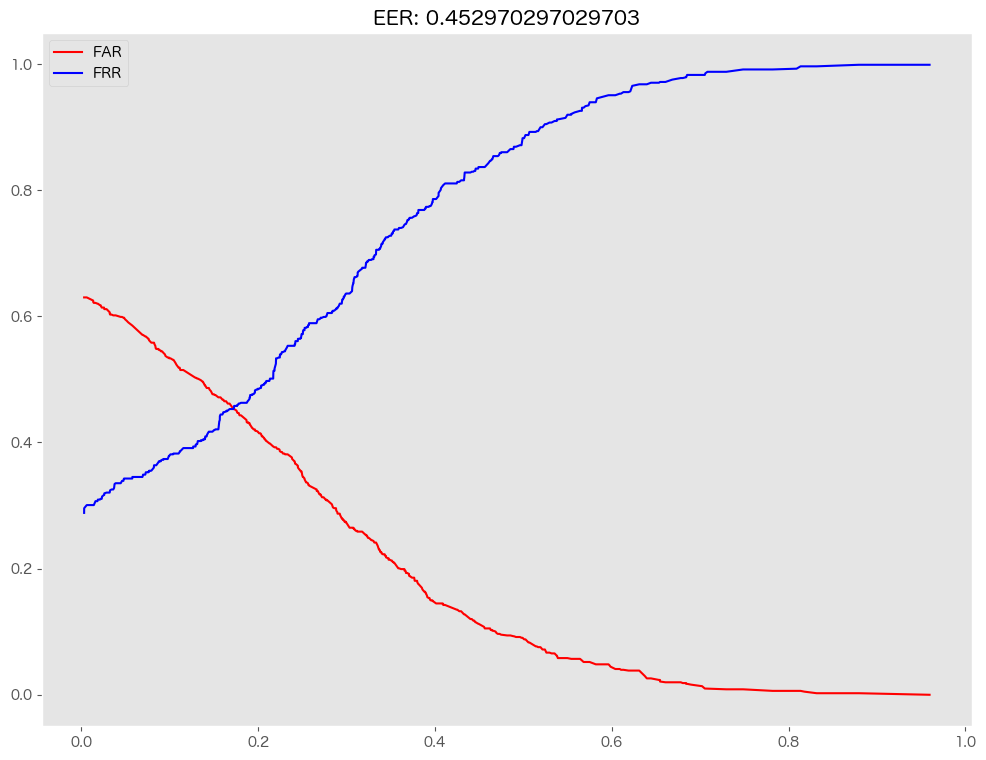

In [52]:
far_kai = pd.DataFrame(far[1:-1]).copy().set_index(threshold[1:-1])
frr_kai = pd.DataFrame(frr[1:-1]).copy().set_index(threshold[1:-1])

fig = plt.figure()
# plt.title(f"{diff_day_1} : {diff_day_2}", loc="left")
plt.title(f"EER: {eer_raw}", loc="center")
# plt.title(f"length: {len(t_T)}:{len(t_Q)}:{len(i_Q)}", loc="right")

far_kai

plt.plot(far_kai, color="r", label="FAR")
plt.plot(frr_kai, color="b", label="FRR")
plt.legend()
plt.grid()
plt.show()